In [1]:
"""
================================================================================
PNEUMONIA DETECTION FROM CHEST X-RAYS - PROJECT SETUP & EXPLORATION
================================================================================

This notebook covers:
1. Kaggle API setup and dataset download
2. Dataset structure verification
3. Comprehensive data exploration and analysis

Author: Omkar Badadale
Date: November 2024
Course: CIS 602 - Fundamentals of Deep Learning
================================================================================
"""

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
Import all required libraries
"""
import os
import sys
from pathlib import Path
import zipfile
import shutil

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Utilities
from tqdm.notebook import tqdm
from collections import Counter

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully!")
print(f"📍 Working directory: {os.getcwd()}")

✅ All libraries imported successfully!
📍 Working directory: /Users/omkarbadadale/Documents/MS Data Science/Fall 25/Fundamentals of DL/pneumonia-detection-cnn/notebooks


In [3]:
import json

def setup_kaggle_credentials():
    """
    Interactive setup for Kaggle API credentials
    """
    kaggle_dir = Path.home() / '.kaggle'
    kaggle_json_path = kaggle_dir / 'kaggle.json'
    
    # Check if credentials already exist
    if kaggle_json_path.exists():
        print("✅ Kaggle credentials already configured!")
        return True
    
    print("🔐 Kaggle API Setup")
    print("-" * 60)
    print("Please download your kaggle.json file from:")
    print("https://www.kaggle.com/settings (API section)")
    print()
    
    # Get path to downloaded kaggle.json
    kaggle_json_input = input("Enter the full path to your kaggle.json file: ").strip()
    
    if not kaggle_json_input:
        print("⚠️ No path provided. Please run this cell again with the correct path.")
        return False
    
    source_path = Path(kaggle_json_input)
    
    if not source_path.exists():
        print(f"❌ File not found: {source_path}")
        print("Please check the path and try again.")
        return False
    
    # Create .kaggle directory
    kaggle_dir.mkdir(exist_ok=True)
    
    # Copy kaggle.json to the correct location
    shutil.copy(source_path, kaggle_json_path)
    
    # Set permissions (Unix-like systems)
    if os.name != 'nt':  # Not Windows
        os.chmod(kaggle_json_path, 0o600)
    
    print(f"✅ Kaggle credentials configured at: {kaggle_json_path}")
    return True

# Run setup
setup_complete = setup_kaggle_credentials()

if setup_complete:
    # Test Kaggle API
    try:
        from kaggle.api.kaggle_api_extended import KaggleApi
        api = KaggleApi()
        api.authenticate()
        print("\n✅ Kaggle API authentication successful!")
    except Exception as e:
        print(f"\n❌ Kaggle API authentication failed: {e}")
        print("Please check your credentials and try again.")

🔐 Kaggle API Setup
------------------------------------------------------------
Please download your kaggle.json file from:
https://www.kaggle.com/settings (API section)

✅ Kaggle credentials configured at: /Users/omkarbadadale/.kaggle/kaggle.json

✅ Kaggle API authentication successful!


In [4]:
"""
Download Chest X-Ray Pneumonia Dataset from Kaggle

Dataset: paultimothymooney/chest-xray-pneumonia
Size: ~2.3 GB
Time: 3-5 minutes depending on connection speed
"""

from kaggle.api.kaggle_api_extended import KaggleApi

def download_chest_xray_dataset():
    """
    Download and extract the chest X-ray dataset
    """
    # Initialize API
    api = KaggleApi()
    api.authenticate()
    
    # Set paths
    dataset_name = 'paultimothymooney/chest-xray-pneumonia'
    download_path = Path('../data/raw')
    download_path.mkdir(parents=True, exist_ok=True)
    
    # Check if dataset already exists
    dataset_dir = download_path / 'chest_xray'
    if dataset_dir.exists() and any(dataset_dir.iterdir()):
        print("✅ Dataset already exists!")
        print(f"📂 Location: {dataset_dir}")
        return dataset_dir
    
    print("📥 Downloading Chest X-Ray Dataset from Kaggle...")
    print(f"   Dataset: {dataset_name}")
    print(f"   Size: ~2.3 GB")
    print(f"   Destination: {download_path}")
    print("\n⏳ This will take 3-5 minutes...\n")
    
    # Download and unzip
    api.dataset_download_files(
        dataset_name,
        path=str(download_path),
        unzip=True
    )
    
    print("\n✅ Download and extraction complete!")
    return dataset_dir

# Download the dataset
dataset_path = download_chest_xray_dataset()
print(f"\n📂 Dataset location: {dataset_path}")

📥 Downloading Chest X-Ray Dataset from Kaggle...
   Dataset: paultimothymooney/chest-xray-pneumonia
   Size: ~2.3 GB
   Destination: ../data/raw

⏳ This will take 3-5 minutes...

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

✅ Download and extraction complete!

📂 Dataset location: ../data/raw/chest_xray


In [5]:
"""
Verify the downloaded dataset structure
"""

def verify_dataset_structure(dataset_path):
    """
    Check and display dataset directory structure
    """
    print("="*80)
    print("DATASET STRUCTURE VERIFICATION")
    print("="*80)
    
    if not dataset_path.exists():
        print(f"❌ Dataset path not found: {dataset_path}")
        return False
    
    # Expected structure
    expected_splits = ['train', 'val', 'test']
    expected_classes = ['NORMAL', 'PNEUMONIA']
    
    dataset_info = {}
    
    for split in expected_splits:
        split_path = dataset_path / split
        
        if not split_path.exists():
            print(f"⚠️ Warning: {split} directory not found!")
            continue
        
        print(f"\n📁 {split.upper()} SET:")
        print("-" * 60)
        
        split_total = 0
        for class_name in expected_classes:
            class_path = split_path / class_name
            
            if class_path.exists():
                # Count images
                image_files = list(class_path.glob('*.jpeg')) + list(class_path.glob('*.jpg'))
                num_images = len(image_files)
                split_total += num_images
                
                # Store info
                if split not in dataset_info:
                    dataset_info[split] = {}
                dataset_info[split][class_name] = num_images
                
                print(f"  {class_name:15s}: {num_images:5d} images")
            else:
                print(f"  {class_name:15s}: ⚠️ Directory not found")
        
        print(f"  {'TOTAL':15s}: {split_total:5d} images")
    
    print("\n" + "="*80)
    
    return dataset_info

# Verify structure
dataset_info = verify_dataset_structure(dataset_path)

# Check for issues
if dataset_info:
    val_total = sum(dataset_info.get('val', {}).values())
    if val_total < 100:
        print(f"\n⚠️ WARNING: Validation set has only {val_total} images!")
        print("   This is too small. We'll need to restructure the splits later.")

DATASET STRUCTURE VERIFICATION

📁 TRAIN SET:
------------------------------------------------------------
  NORMAL         :  1341 images
  PNEUMONIA      :  3875 images
  TOTAL          :  5216 images

📁 VAL SET:
------------------------------------------------------------
  NORMAL         :     8 images
  PNEUMONIA      :     8 images
  TOTAL          :    16 images

📁 TEST SET:
------------------------------------------------------------
  NORMAL         :   234 images
  PNEUMONIA      :   390 images
  TOTAL          :   624 images


⚠️ WARNING: Validation set has only 16 images!
   This is too small. We'll need to restructure the splits later.


In [6]:
"""
Create a structured summary of the dataset
"""

def create_dataset_summary(dataset_info):
    """
    Convert dataset info to a pandas DataFrame for easy analysis
    """
    data_rows = []
    
    for split in ['train', 'val', 'test']:
        if split in dataset_info:
            for class_name in ['NORMAL', 'PNEUMONIA']:
                if class_name in dataset_info[split]:
                    data_rows.append({
                        'Split': split,
                        'Class': class_name,
                        'Count': dataset_info[split][class_name]
                    })
    
    df = pd.DataFrame(data_rows)
    return df

# Create summary
df_summary = create_dataset_summary(dataset_info)

print("📊 DATASET SUMMARY")
print("="*80)
print(df_summary.to_string(index=False))
print("\n" + "="*80)

# Calculate statistics
total_images = df_summary['Count'].sum()
print(f"\n📈 STATISTICS:")
print(f"   Total images: {total_images:,}")

for split in ['train', 'val', 'test']:
    split_total = df_summary[df_summary['Split'] == split]['Count'].sum()
    percentage = (split_total / total_images) * 100
    print(f"   {split.capitalize():12s}: {split_total:5d} ({percentage:5.1f}%)")

print(f"\n   Class Distribution:")
for class_name in ['NORMAL', 'PNEUMONIA']:
    class_total = df_summary[df_summary['Class'] == class_name]['Count'].sum()
    percentage = (class_total / total_images) * 100
    print(f"   {class_name:12s}: {class_total:5d} ({percentage:5.1f}%)")

# Calculate imbalance ratio
normal_count = df_summary[df_summary['Class'] == 'NORMAL']['Count'].sum()
pneumonia_count = df_summary[df_summary['Class'] == 'PNEUMONIA']['Count'].sum()
imbalance_ratio = pneumonia_count / normal_count

print(f"\n⚖️  Imbalance Ratio: {imbalance_ratio:.2f}:1 (PNEUMONIA:NORMAL)")

📊 DATASET SUMMARY
Split     Class  Count
train    NORMAL   1341
train PNEUMONIA   3875
  val    NORMAL      8
  val PNEUMONIA      8
 test    NORMAL    234
 test PNEUMONIA    390


📈 STATISTICS:
   Total images: 5,856
   Train       :  5216 ( 89.1%)
   Val         :    16 (  0.3%)
   Test        :   624 ( 10.7%)

   Class Distribution:
   NORMAL      :  1583 ( 27.0%)
   PNEUMONIA   :  4273 ( 73.0%)

⚖️  Imbalance Ratio: 2.70:1 (PNEUMONIA:NORMAL)


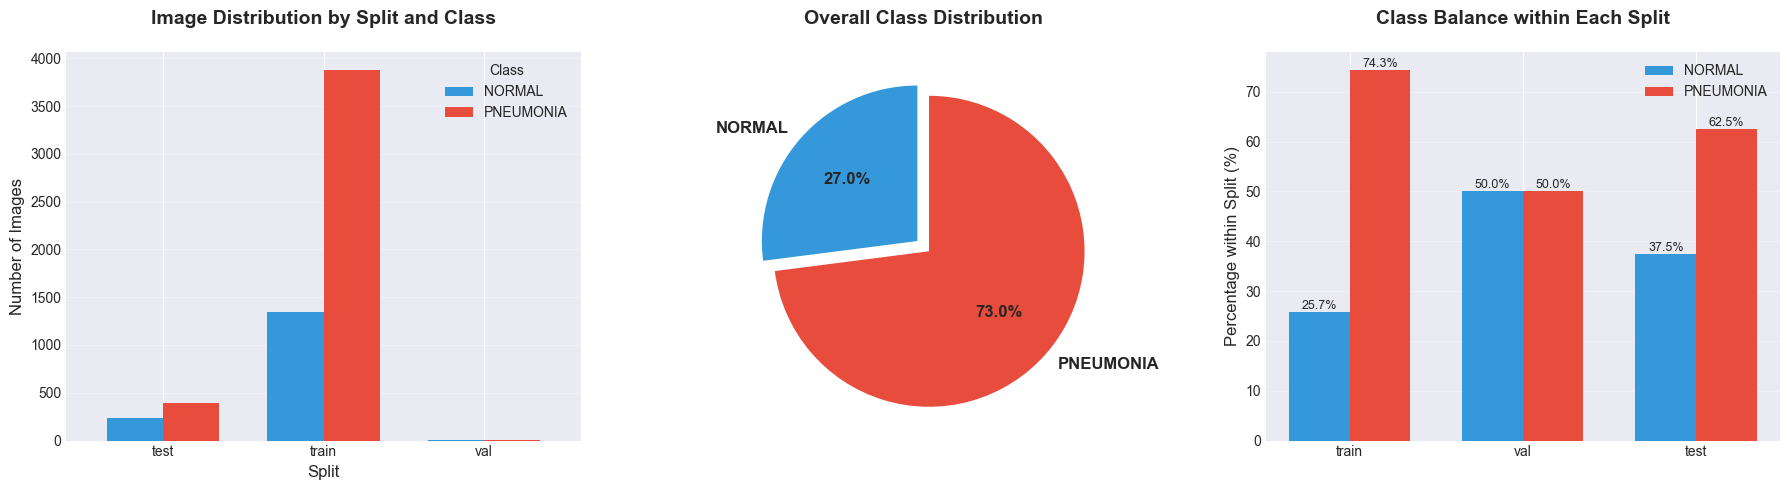

✅ Visualization saved: results/figures/01_class_distribution.png


In [7]:
"""
Visualize the class distribution across splits
"""

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Stacked bar chart by split
df_pivot = df_summary.pivot(index='Split', columns='Class', values='Count')
df_pivot.plot(kind='bar', stacked=False, ax=axes[0], color=['#3498db', '#e74c3c'], width=0.7)
axes[0].set_title('Image Distribution by Split and Class', fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel('Split', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].legend(title='Class', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Plot 2: Overall class distribution (pie chart)
class_totals = df_summary.groupby('Class')['Count'].sum()
colors = ['#3498db', '#e74c3c']
explode = (0.05, 0.05)

axes[1].pie(class_totals, labels=class_totals.index, autopct='%1.1f%%',
            startangle=90, colors=colors, explode=explode,
            textprops={'fontsize': 12, 'weight': 'bold'})
axes[1].set_title('Overall Class Distribution', fontsize=14, fontweight='bold', pad=20)

# Plot 3: Percentage breakdown by split
df_percentage = df_summary.copy()
df_percentage['Percentage'] = df_percentage.groupby('Split')['Count'].transform(lambda x: 100 * x / x.sum())

splits = ['train', 'val', 'test']
normal_pct = [df_percentage[(df_percentage['Split'] == s) & (df_percentage['Class'] == 'NORMAL')]['Percentage'].values[0] 
              if len(df_percentage[(df_percentage['Split'] == s) & (df_percentage['Class'] == 'NORMAL')]) > 0 else 0 
              for s in splits]
pneumonia_pct = [df_percentage[(df_percentage['Split'] == s) & (df_percentage['Class'] == 'PNEUMONIA')]['Percentage'].values[0]
                 if len(df_percentage[(df_percentage['Split'] == s) & (df_percentage['Class'] == 'PNEUMONIA')]) > 0 else 0
                 for s in splits]

x = np.arange(len(splits))
width = 0.35

bars1 = axes[2].bar(x - width/2, normal_pct, width, label='NORMAL', color='#3498db')
bars2 = axes[2].bar(x + width/2, pneumonia_pct, width, label='PNEUMONIA', color='#e74c3c')

axes[2].set_ylabel('Percentage within Split (%)', fontsize=12)
axes[2].set_title('Class Balance within Each Split', fontsize=14, fontweight='bold', pad=20)
axes[2].set_xticks(x)
axes[2].set_xticklabels(splits)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../results/figures/01_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: results/figures/01_class_distribution.png")

📸 Displaying sample images...



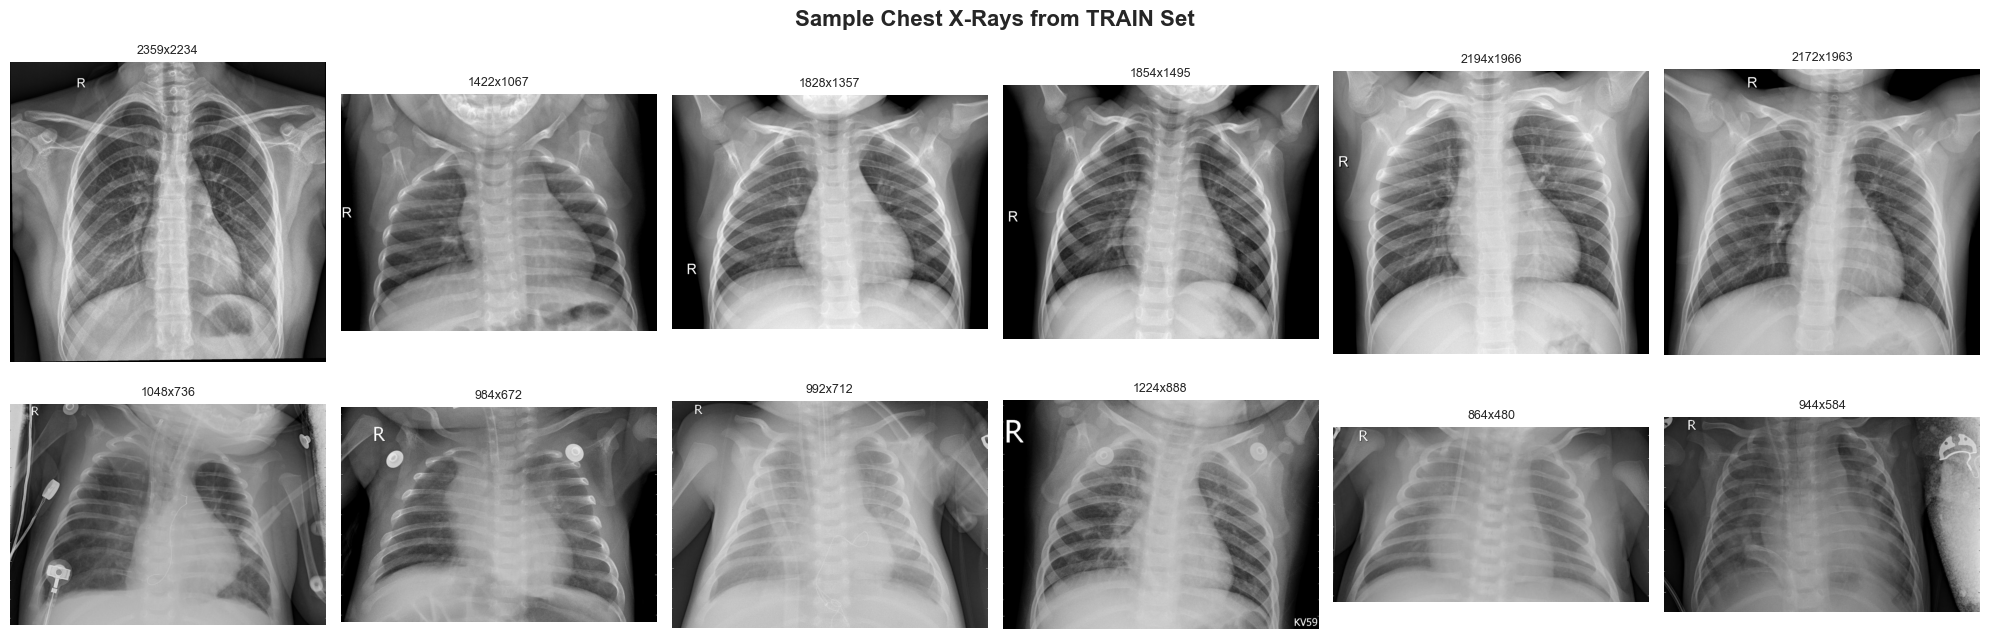


✅ Visualization saved: results/figures/02_sample_images_train.png


In [8]:
"""
Display sample images from each class
"""

def display_sample_images(dataset_path, split='train', num_samples=6):
    """
    Display sample images from both classes
    """
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 7))
    
    for row_idx, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
        class_path = dataset_path / split / class_name
        image_files = list(class_path.glob('*.jpeg'))[:num_samples]
        
        for col_idx, img_path in enumerate(image_files):
            # Read image
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            
            # Display
            axes[row_idx, col_idx].imshow(img, cmap='gray')
            
            # Title
            if col_idx == 0:
                axes[row_idx, col_idx].set_ylabel(class_name, 
                                                   fontsize=14, 
                                                   fontweight='bold',
                                                   rotation=0,
                                                   labelpad=40,
                                                   va='center')
            
            axes[row_idx, col_idx].set_title(f'{img.shape[1]}x{img.shape[0]}', 
                                             fontsize=9)
            axes[row_idx, col_idx].axis('off')
    
    plt.suptitle(f'Sample Chest X-Rays from {split.upper()} Set', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(f'../results/figures/02_sample_images_{split}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

# Display samples
print("📸 Displaying sample images...\n")
display_sample_images(dataset_path, split='train', num_samples=6)
print("\n✅ Visualization saved: results/figures/02_sample_images_train.png")

In [9]:
"""
Analyze image dimensions across the dataset
"""

def analyze_image_dimensions(dataset_path, split='train', num_samples=200):
    """
    Analyze width, height, and aspect ratio of images
    """
    print(f"📐 Analyzing image dimensions ({num_samples} samples per class)...\n")
    
    stats = {}
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = dataset_path / split / class_name
        image_files = list(class_path.glob('*.jpeg'))[:num_samples]
        
        widths, heights, aspects = [], [], []
        
        for img_path in tqdm(image_files, desc=f"  {class_name}", leave=False):
            img = Image.open(img_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
            aspects.append(w/h)
        
        stats[class_name] = {
            'widths': widths,
            'heights': heights,
            'aspects': aspects
        }
        
        print(f"{class_name}:")
        print(f"  Width:  {np.mean(widths):7.0f} ± {np.std(widths):6.0f} px "
              f"(range: {min(widths):4d} - {max(widths):4d})")
        print(f"  Height: {np.mean(heights):7.0f} ± {np.std(heights):6.0f} px "
              f"(range: {min(heights):4d} - {max(heights):4d})")
        print(f"  Aspect: {np.mean(aspects):7.2f} ± {np.std(aspects):6.2f}\n")
    
    return stats

# Analyze dimensions
dimension_stats = analyze_image_dimensions(dataset_path, split='train', num_samples=200)

📐 Analyzing image dimensions (200 samples per class)...



  NORMAL:   0%|          | 0/200 [00:00<?, ?it/s]

NORMAL:
  Width:     1704 ±    300 px (range: 1056 - 2572)
  Height:    1426 ±    356 px (range:  792 - 2663)
  Aspect:    1.22 ±   0.13



  PNEUMONIA:   0%|          | 0/200 [00:00<?, ?it/s]

PNEUMONIA:
  Width:     1195 ±    254 px (range:  384 - 2000)
  Height:     818 ±    243 px (range:  127 - 1806)
  Aspect:    1.51 ±   0.25



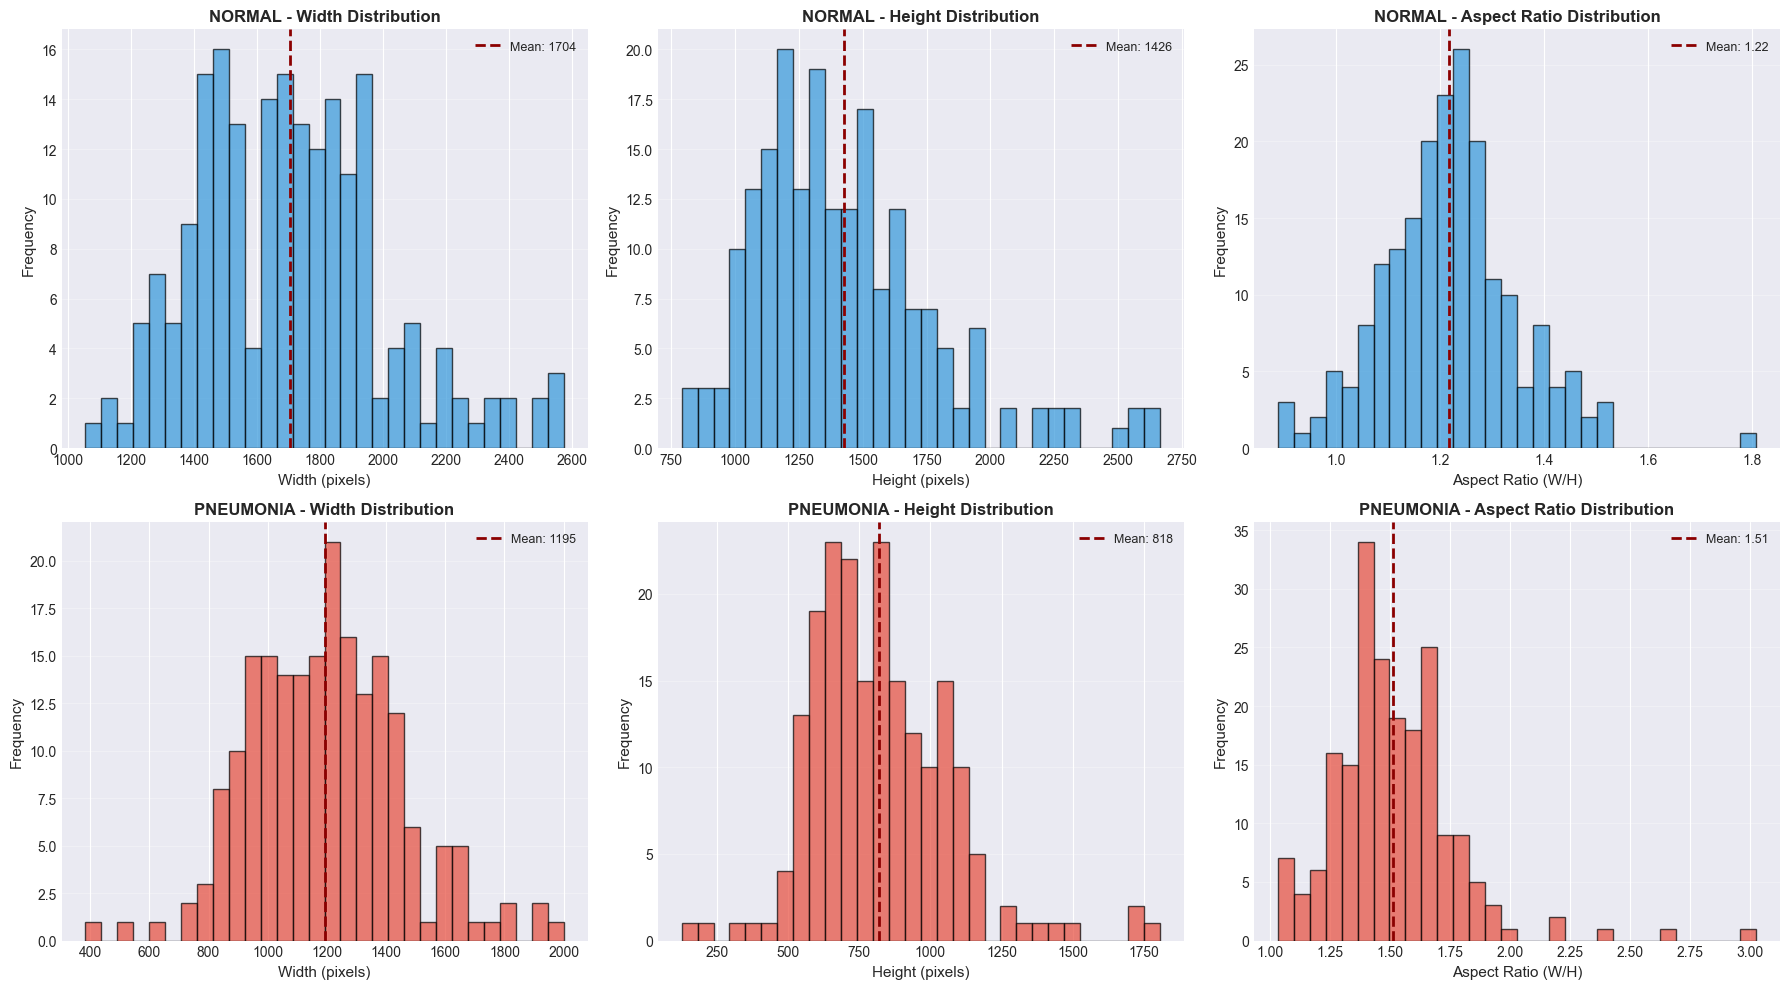

✅ Visualization saved: results/figures/03_dimension_distributions.png

💡 Insight: Images have varying sizes → We'll resize to 224x224 for training


In [10]:
"""
Visualize dimension distributions
"""

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['widths', 'heights', 'aspects']
titles = ['Width Distribution', 'Height Distribution', 'Aspect Ratio Distribution']
xlabels = ['Width (pixels)', 'Height (pixels)', 'Aspect Ratio (W/H)']

for row_idx, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
    color = '#3498db' if class_name == 'NORMAL' else '#e74c3c'
    
    for col_idx, (metric, title, xlabel) in enumerate(zip(metrics, titles, xlabels)):
        ax = axes[row_idx, col_idx]
        data = dimension_stats[class_name][metric]
        
        # Histogram
        ax.hist(data, bins=30, color=color, alpha=0.7, edgecolor='black')
        
        # Add mean line
        mean_val = np.mean(data)
        ax.axvline(mean_val, color='darkred', linestyle='--', linewidth=2, 
                   label=f'Mean: {mean_val:.0f}' if metric != 'aspects' else f'Mean: {mean_val:.2f}')
        
        # Labels
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f'{class_name} - {title}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/03_dimension_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: results/figures/03_dimension_distributions.png")
print("\n💡 Insight: Images have varying sizes → We'll resize to 224x224 for training")

In [11]:
"""
Analyze pixel intensity distributions
"""

def analyze_pixel_intensity(dataset_path, split='train', num_samples=100):
    """
    Analyze mean and std of pixel intensities
    """
    print(f"🔍 Analyzing pixel intensities ({num_samples} samples per class)...\n")
    
    intensity_stats = {}
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = dataset_path / split / class_name
        image_files = list(class_path.glob('*.jpeg'))[:num_samples]
        
        means, stds = [], []
        
        for img_path in tqdm(image_files, desc=f"  {class_name}", leave=False):
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            means.append(np.mean(img))
            stds.append(np.std(img))
        
        intensity_stats[class_name] = {
            'means': means,
            'stds': stds
        }
        
        print(f"{class_name}:")
        print(f"  Mean intensity: {np.mean(means):6.2f} ± {np.std(means):5.2f}")
        print(f"  Std  intensity: {np.mean(stds):6.2f} ± {np.std(stds):5.2f}\n")
    
    return intensity_stats

# Analyze intensities
intensity_stats = analyze_pixel_intensity(dataset_path, split='train', num_samples=100)

🔍 Analyzing pixel intensities (100 samples per class)...



  NORMAL:   0%|          | 0/100 [00:00<?, ?it/s]

NORMAL:
  Mean intensity: 122.33 ± 14.75
  Std  intensity:  61.77 ±  5.47



  PNEUMONIA:   0%|          | 0/100 [00:00<?, ?it/s]

PNEUMONIA:
  Mean intensity: 123.66 ± 19.78
  Std  intensity:  54.06 ± 10.72



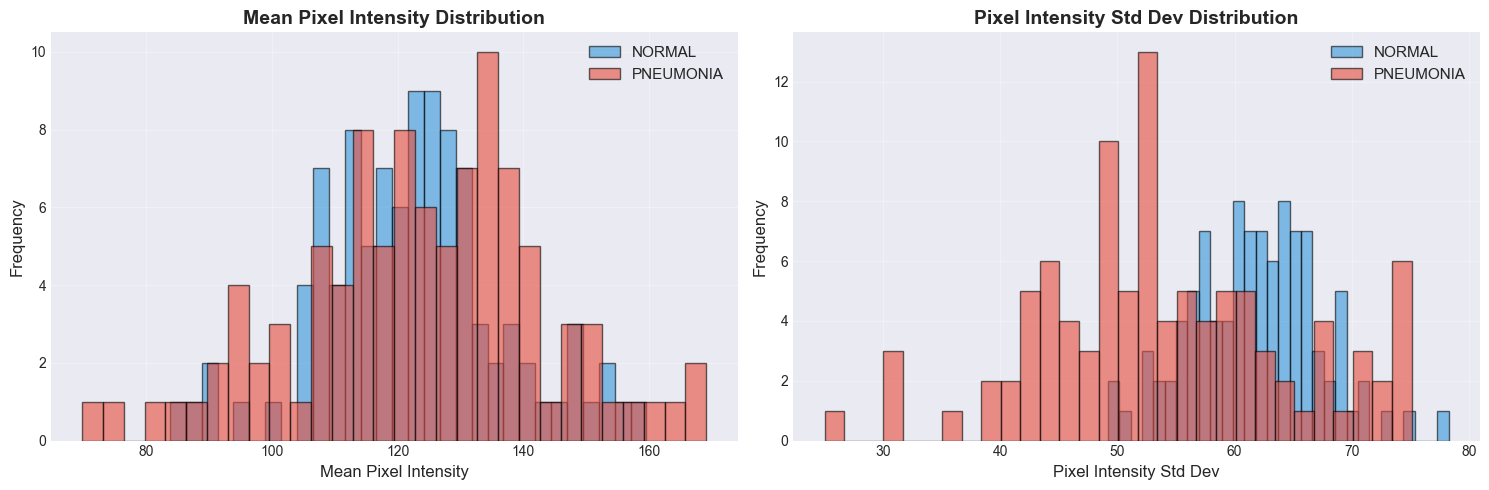

✅ Visualization saved: results/figures/04_intensity_distributions.png

💡 Insight: Similar intensity distributions between classes
   → We'll use ImageNet normalization: mean=0.485, std=0.229


In [12]:
"""
Visualize pixel intensity distributions
"""

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Mean intensity comparison
axes[0].hist(intensity_stats['NORMAL']['means'], bins=30, alpha=0.6, 
             label='NORMAL', color='#3498db', edgecolor='black')
axes[0].hist(intensity_stats['PNEUMONIA']['means'], bins=30, alpha=0.6, 
             label='PNEUMONIA', color='#e74c3c', edgecolor='black')
axes[0].set_xlabel('Mean Pixel Intensity', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Mean Pixel Intensity Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Std intensity comparison
axes[1].hist(intensity_stats['NORMAL']['stds'], bins=30, alpha=0.6, 
             label='NORMAL', color='#3498db', edgecolor='black')
axes[1].hist(intensity_stats['PNEUMONIA']['stds'], bins=30, alpha=0.6, 
             label='PNEUMONIA', color='#e74c3c', edgecolor='black')
axes[1].set_xlabel('Pixel Intensity Std Dev', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Pixel Intensity Std Dev Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/04_intensity_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: results/figures/04_intensity_distributions.png")
print("\n💡 Insight: Similar intensity distributions between classes")
print("   → We'll use ImageNet normalization: mean=0.485, std=0.229")

In [13]:
"""
Summary of data exploration
"""

print("\n" + "="*80)
print("DATA EXPLORATION SUMMARY")
print("="*80)

print("\n📊 DATASET OVERVIEW:")
print(f"  • Total images:     {df_summary['Count'].sum():,}")
print(f"  • Training set:     {df_summary[df_summary['Split']=='train']['Count'].sum():,} images")
print(f"  • Validation set:   {df_summary[df_summary['Split']=='val']['Count'].sum():,} images")
print(f"  • Test set:         {df_summary[df_summary['Split']=='test']['Count'].sum():,} images")

print("\n⚖️  CLASS DISTRIBUTION:")
print(f"  • NORMAL:           {df_summary[df_summary['Class']=='NORMAL']['Count'].sum():,} images ({(df_summary[df_summary['Class']=='NORMAL']['Count'].sum()/df_summary['Count'].sum()*100):.1f}%)")
print(f"  • PNEUMONIA:        {df_summary[df_summary['Class']=='PNEUMONIA']['Count'].sum():,} images ({(df_summary[df_summary['Class']=='PNEUMONIA']['Count'].sum()/df_summary['Count'].sum()*100):.1f}%)")
print(f"  • Imbalance ratio:  {imbalance_ratio:.2f}:1")

print("\n📐 IMAGE PROPERTIES:")
print(f"  • Grayscale images (1 channel)")
print(f"  • Varying dimensions (will resize to 224×224)")
print(f"  • Average size: ~{np.mean([np.mean(dimension_stats[c]['widths']) for c in ['NORMAL', 'PNEUMONIA']]):.0f}×{np.mean([np.mean(dimension_stats[c]['heights']) for c in ['NORMAL', 'PNEUMONIA']]):.0f} pixels")

print("\n🔍 KEY INSIGHTS:")
print("  1. ⚠️  Validation set has only 16 images (too small!)")
print("      → Need to restructure splits to 70%/15%/15%")
print("  2. ⚖️  3:1 class imbalance (PNEUMONIA:NORMAL)")
print("      → Will address with Focal Loss")
print("  3. 📏 Varying image sizes")
print("      → Will standardize to 224×224 pixels")
print("  4. 💡 Similar intensity distributions")
print("      → Will use standard ImageNet normalization")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("✅ Step 1: Dataset downloaded and explored")
print("🔄 Step 2: Restructure validation set and create data loaders")
print("🔄 Step 3: Build and train baseline CNN model")
print("🔄 Step 4: Implement attention mechanisms")
print("🔄 Step 5: Add focal loss and learning rate scheduling")
print("🔄 Step 6: Final evaluation and visualization")
print("="*80)


DATA EXPLORATION SUMMARY

📊 DATASET OVERVIEW:
  • Total images:     5,856
  • Training set:     5,216 images
  • Validation set:   16 images
  • Test set:         624 images

⚖️  CLASS DISTRIBUTION:
  • NORMAL:           1,583 images (27.0%)
  • PNEUMONIA:        4,273 images (73.0%)
  • Imbalance ratio:  2.70:1

📐 IMAGE PROPERTIES:
  • Grayscale images (1 channel)
  • Varying dimensions (will resize to 224×224)
  • Average size: ~1450×1122 pixels

🔍 KEY INSIGHTS:
  1. ⚠️  Validation set has only 16 images (too small!)
      → Need to restructure splits to 70%/15%/15%
  2. ⚖️  3:1 class imbalance (PNEUMONIA:NORMAL)
      → Will address with Focal Loss
  3. 📏 Varying image sizes
      → Will standardize to 224×224 pixels
  4. 💡 Similar intensity distributions
      → Will use standard ImageNet normalization

NEXT STEPS
✅ Step 1: Dataset downloaded and explored
🔄 Step 2: Restructure validation set and create data loaders
🔄 Step 3: Build and train baseline CNN model
🔄 Step 4: Implement a

In [14]:
"""
Save important information for next notebooks
"""

# Create a configuration dictionary
config = {
    'dataset_path': str(dataset_path),
    'total_images': int(df_summary['Count'].sum()),
    'train_size': int(df_summary[df_summary['Split']=='train']['Count'].sum()),
    'val_size': int(df_summary[df_summary['Split']=='val']['Count'].sum()),
    'test_size': int(df_summary[df_summary['Split']=='test']['Count'].sum()),
    'normal_count': int(df_summary[df_summary['Class']=='NORMAL']['Count'].sum()),
    'pneumonia_count': int(df_summary[df_summary['Class']=='PNEUMONIA']['Count'].sum()),
    'imbalance_ratio': float(imbalance_ratio),
    'target_image_size': 224,
    'normalization_mean': 0.485,
    'normalization_std': 0.229
}

# Save to file
import json
config_path = Path('../config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)

print(f"✅ Configuration saved to: {config_path}")
print("\nSaved configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

✅ Configuration saved to: ../config.json

Saved configuration:
  dataset_path: ../data/raw/chest_xray
  total_images: 5856
  train_size: 5216
  val_size: 16
  test_size: 624
  normal_count: 1583
  pneumonia_count: 4273
  imbalance_ratio: 2.6993051168667086
  target_image_size: 224
  normalization_mean: 0.485
  normalization_std: 0.229
